### Try different optimizer to finetune the learningrate better

In [1]:
#%pylab inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
np.set_printoptions(precision = 6)
import datetime
matplotlib.rcParams['figure.figsize'] = [6, 4]
plt.rcParams['image.cmap'] = 'jet'
plt.rcParams['image.interpolation']='catrom'
from vampnet import data_generator

/storage/mi/pasquali/miniconda3/envs/deeptime/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
import tensorflow as tf
import scipy.io
import binascii
import pyemma as py
import mdshare
import vampnet
import mdtraj as md

/storage/mi/pasquali/miniconda3/envs/deeptime/lib/python3.6/site-packages/pyemma/__init__.py:91: UserWarning: You are not using the latest release of PyEMMA. Latest is 2.5.2, you have 2.4.
  .format(latest=latest, current=current), category=UserWarning)


In [3]:
traj_whole, dihedral = data_generator.get_alanine_data()

# traj_whole = np.concatenate([np.sin(dihedral), np.cos(dihedral)], axis = 1)

traj_data_points, input_size = traj_whole.shape

In [4]:
batch_size = 8000
batch_size_gen = 1500
#batch_size_latent = 1024
tau = 1

train_ratio = 0.9

lr_koop = 1e-5
lr_gen = 1e-4

output_size = 6

nodes = [input_size, 100, 100, 100, output_size]

load_model = True
load_gen_model = False

res_block_len = 3
regularizer = 1e-10
dropout = 0.#0.5# 0.2
energy_distant = True # if false Moment matching
if not energy_distant:
    sigma_kernel = np.array([[0.1, 1. ,5., 10., 15.]], dtype=np.float32)# can be tuned for each kernel in principal
random_size = 6
sample_before = True
conditioned_dist = True
equal_starting_state = False # starting point qually likely from each state
if equal_starting_state:
    conditioned_dist = False
    print('Turned conditioned_dist down, equal starting higher priority')
sample_training_data_for_gen_before = True
sqrt = True
col_gen = 'gen'
nodes_gen = [output_size + random_size, 100, 100, 100, 100, 100, input_size]


dict_variables = {}

In [5]:
# Select the state to be filtered out
# 0 top left, 1 top right, 2 bottom left, 3 bottom right
state_to_be_filtered = 4


# samples of the original trajectory which are closest to the center of each state
state_centers = [8108, 133869, 0, 19678, 174924, 94042]

# Filters used for each state
filter_boxes = np.array([
    [[-np.pi, -1.8],[ 1.8, -2.0]],
    [[  -1.8, -0.3],[ 1.4, -2.0]],
    [[-np.pi, -1.8],[-2.0,  1.8]],
    [[  -1.9, -0.3],[-2.0,  1.4]],
    [[     0,    2],[  -2,    2]],
    [[     0,    2],[   2,   -2]]
])
state_filt_index = state_centers[state_to_be_filtered]
filtbox = filter_boxes[state_to_be_filtered]


mplt_filt1 = [[filtbox[0,0],filtbox[1,0]], filtbox[0,1] - filtbox[0,0], filtbox[1,1] - filtbox[1,0]]
mplt_filt2 = None

if filtbox[1,0] > filtbox[1,1]:
    mplt_filt1 = [[filtbox[0,0],-np.pi], filtbox[0,1] - filtbox[0,0], filtbox[1,1] + np.pi]
    mplt_filt2 = [[filtbox[0,0],filtbox[1,0]], filtbox[0,1] - filtbox[0,0], np.pi - filtbox[1,0]]

def get_filter(tau, dih, filt_shape, circle = False):
            
    dht_1 = np.array(dih[:-tau].T)
    dht_2 = np.array(dih[tau:].T)
    
    if circle:
    
        center = [-2.5,0]
        radius = [0.8, 1]
        
        for dht in [dht_1, dht_2]:
            for d, c, r in zip(dht, center, radius):
                d -= c
                d /= r

        cond_1 = dht_1[0]**2 + dht_1[1]**2 > 1
        cond_2 = dht_2[0]**2 + dht_2[1]**2 > 1
        
        indexes_filt = np.where(np.all([cond_1, cond_2], axis = 0))[0]
    
        return indexes_filt
        
    else:
        
        xlim = filt_shape[0]
        ylim1 = filt_shape[1]
        
        if ylim1[0] < ylim1[1]:
            ylim2 = [0,0]
        else:
            ylim2  = [-np.pi, ylim1[1]]
            ylim1[1] = np.pi
        
        conds = []
        
        for ylim in [ylim1, ylim2]:
            for index_dht, dht in enumerate([dht_1, dht_2]):

                cond_x = np.any([dht[0] < xlim[0], dht[0] > xlim[1]], axis = 0)
                cond_y = np.any([dht[1] < ylim[0], dht[1] > ylim[1]], axis = 0)

                conds.append(np.any([cond_x, cond_y], axis = 0))
        
        
        indexes_filt = np.where(np.all(conds, axis = 0))[0]

        return indexes_filt

In [6]:
filter_data = False

if filter_data:
    length_data_whole = traj_data_points - tau

    indexes_filt = get_filter(tau, dihedral, filtbox)

    length_data = indexes_filt.shape[0]

    traj_ord = traj_whole[:-tau][indexes_filt]
    traj_ord_lag = traj_whole[tau:][indexes_filt]

    shuffle_index = np.arange(length_data)

    np.random.shuffle(shuffle_index)

    traj = traj_ord[shuffle_index]
    traj_lag = traj_ord_lag[shuffle_index]

    dihedral_filt = dihedral[:-tau][indexes_filt]


else:
    length_data = traj_data_points - tau

    traj_ord = traj_whole[:-tau]
    traj_ord_lag = traj_whole[tau:]

    shuffle_index = np.arange(length_data)

    np.random.shuffle(shuffle_index)

    traj = traj_ord[shuffle_index]
    traj_lag = traj_ord_lag[shuffle_index]

    dihedral_filt = dihedral[:-tau]

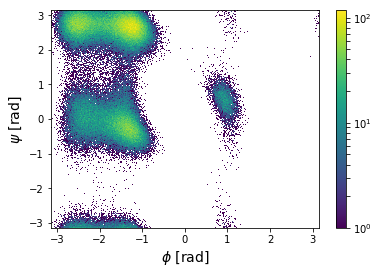

In [7]:
fig, ax = plt.subplots()

range_mat = np.array([[-np.pi,np.pi],[-np.pi,np.pi]])

hist_im = ax.hist2d(dihedral[:,0], dihedral[:,1], bins=300, range = range_mat, norm=matplotlib.colors.LogNorm(), cmap = plt.cm.viridis)
ax.set_xlim(-np.pi,np.pi)
ax.set_ylim(-np.pi,np.pi)

if filter_data:
    ax.scatter(dihedral[state_filt_index,0], dihedral[state_filt_index,1], s=40, c='C3')
    e = matplotlib.patches.Rectangle(*mplt_filt1, color='C1')
    e.set_clip_box(ax.bbox)
    e.set_alpha(0.2)
    ax.add_artist(e)

    if mplt_filt2:
        e2 = matplotlib.patches.Rectangle(*mplt_filt2, color='C1')
        e2.set_clip_box(ax.bbox)
        e2.set_alpha(0.2)
        ax.add_artist(e2)
    
font = {'fontsize': 14}
# ax.set_xticks([-3,0,3])
# # ax.set_yticks([-3,0,3])
# ax.set_xticklabels([r'-$\pi$','0', r'$\pi$'], fontdict=font)
# ax.set_yticklabels([r'-$\pi$','0', r'$\pi$'], fontdict=font)
ax.set_xlabel(r'$\phi$ [rad]', fontsize = 14)
ax.set_ylabel(r'$\psi$ [rad]', fontsize = 14)
plt.colorbar(hist_im[-1], ax = ax)
# fig.savefig('training_data_overlay_{}state.pdf'.format(state_to_be_filtered), bbox_inches='tight')
plt.show()

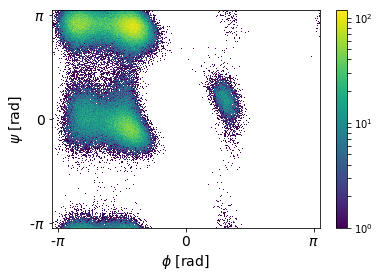

In [8]:
fig, ax = plt.subplots()

range_mat = np.array([[-np.pi,np.pi],[-np.pi,np.pi]])

hist_im = ax.hist2d(dihedral_filt[:,0], dihedral_filt[:,1], bins=300, range = range_mat, norm=matplotlib.colors.LogNorm(), cmap = plt.cm.viridis)
if filter_data:
    ax.scatter(dihedral[state_filt_index,0], dihedral[state_filt_index,1], s=40, c='C3')
    
ax.set_xlim(-np.pi,np.pi)
ax.set_ylim(-np.pi,np.pi)
font = {'fontsize': 14}
ax.set_xticks([-3,0,3])
ax.set_yticks([-3,0,3])
ax.set_xticklabels([r'-$\pi$','0', r'$\pi$'], fontdict=font)
ax.set_yticklabels([r'-$\pi$','0', r'$\pi$'], fontdict=font)
ax.set_xlabel(r'$\phi$ [rad]', fontsize = 14)
ax.set_ylabel(r'$\psi$ [rad]', fontsize = 14)
plt.colorbar(hist_im[-1], ax = ax)
fig.savefig('training_data_removed_{}state.pdf'.format(state_to_be_filtered), bbox_inches='tight')
plt.show()

In [9]:
length_train = int(np.floor(length_data * train_ratio))
length_vali = length_data - length_train

traj_data_train = traj[:length_train]
traj_data_train_lag = traj_lag[:length_train]

traj_data_valid = traj[length_train:]
traj_data_valid_lag = traj_lag[length_train:]

# Input of the first network
X1_train = traj_data_train.astype('float32')
X2_train  = traj_data_train_lag.astype('float32')

# Input for validation
X1_vali = traj_data_valid.astype('float32')
X2_vali = traj_data_valid_lag.astype('float32')

In [10]:
def create_layer(in_size, out_size, col):
    w = tf.get_variable(shape = [in_size, out_size], initializer=tf.contrib.layers.xavier_initializer(), name='W', collections = [col])
    b = tf.get_variable(initializer=tf.constant(0., shape = [out_size]), name='b', collections = [col])
    return w,b

In [11]:
def chi(x_t, nodes, block_len = 3, name='chi', col = 'koopman'):
    
    dict_variables[name] = {}
    with tf.variable_scope(name):
        layer = tf.identity(x_t, name = 'input')
        
        layer = tf.layers.batch_normalization(layer)
        len_net = len(nodes)
        for i in range(len_net - 2):
            block_name = 'block_'+str(i+1)
            with tf.variable_scope(block_name):
                dict_variables[name][block_name] = {}
                w,b = create_layer(nodes[i], nodes[i+1], col)
                
                dict_variables[name][block_name]['layer_0'] = {}
                dict_variables[name][block_name]['layer_0']['W'] = w
                dict_variables[name][block_name]['layer_0']['b'] = b
                
                layer = tf.nn.dropout(tf.nn.elu(tf.matmul(layer, w) + b), keep_prob_drop)
                layer = tf.layers.batch_normalization(layer)
                layer_i = tf.identity(layer)
                for block_n in range(block_len-1):
                    layer_name = 'layer_'+str(block_n+1)
                    with tf.variable_scope(layer_name):
                        w,b = create_layer(nodes[i+1], nodes[i+1], col)
                        
                        dict_variables[name][block_name][layer_name] = {}
                        dict_variables[name][block_name][layer_name]['W'] = w
                        dict_variables[name][block_name][layer_name]['b'] = b
                        
                        layer_i = tf.nn.dropout(tf.nn.elu(tf.matmul(layer_i, w) + b), keep_prob_drop)
                        layer_i = tf.layers.batch_normalization(layer_i)
                with tf.variable_scope('layer_'+str(block_n+2)):
                    w,b = create_layer(nodes[i+1], nodes[i+1], col)
                    
                    dict_variables[name][block_name]['layer_'+str(block_n+2)] = {}
                    dict_variables[name][block_name]['layer_'+str(block_n+2)]['W'] = w
                    dict_variables[name][block_name]['layer_'+str(block_n+2)]['b'] = b
                    
                    layer_i = tf.matmul(layer_i, w) + b
                    layer = tf.nn.dropout(tf.nn.elu(tf.add(layer,layer_i)), keep_prob_drop)
                    layer = tf.layers.batch_normalization(layer)
        with tf.variable_scope('output_layer'):
            
            w,b = create_layer(nodes[-2], nodes[-1], col)
            
            dict_variables[name]['output_layer'] = {}
            dict_variables[name]['output_layer']['W'] = w
            dict_variables[name]['output_layer']['b'] = b
            
            output = tf.nn.softmax(layer @ w + b)
    return output

In [12]:
def gamma(x_t, nodes, block_len = 3, name='gamma', col = 'koopman'):
    
    dict_variables[name] = {}
    with tf.variable_scope(name):
        layer = tf.identity(x_t, name = 'input')
        
        layer = tf.layers.batch_normalization(layer)
        len_net = len(nodes)
        for i in range(len_net - 2):
            block_name = 'block_'+str(i+1)
            with tf.variable_scope(block_name):
                dict_variables[name][block_name] = {}
                w,b = create_layer(nodes[i], nodes[i+1], col)
                
                dict_variables[name][block_name]['layer_0'] = {}
                dict_variables[name][block_name]['layer_0']['W'] = w
                dict_variables[name][block_name]['layer_0']['b'] = b
                
                layer = tf.nn.dropout(tf.nn.elu(tf.matmul(layer, w) + b), keep_prob_drop)
                layer = tf.layers.batch_normalization(layer)
                layer_i = tf.identity(layer)
                for block_n in range(block_len-1):
                    layer_name = 'layer_'+str(block_n+1)
                    with tf.variable_scope(layer_name):
                        w,b = create_layer(nodes[i+1], nodes[i+1], col)
                        
                        dict_variables[name][block_name][layer_name] = {}
                        dict_variables[name][block_name][layer_name]['W'] = w
                        dict_variables[name][block_name][layer_name]['b'] = b
                        
                        layer_i = tf.nn.dropout(tf.nn.elu(tf.matmul(layer_i, w) + b), keep_prob_drop)
                        layer_i = tf.layers.batch_normalization(layer_i)
                with tf.variable_scope('layer_'+str(block_n+2)):
                    w,b = create_layer(nodes[i+1], nodes[i+1], col)
                    
                    dict_variables[name][block_name]['layer_'+str(block_n+2)] = {}
                    dict_variables[name][block_name]['layer_'+str(block_n+2)]['W'] = w
                    dict_variables[name][block_name]['layer_'+str(block_n+2)]['b'] = b
                    
                    layer_i = tf.matmul(layer_i, w) + b
                    layer = tf.nn.dropout(tf.nn.elu(tf.add(layer,layer_i)), keep_prob_drop)
                    layer = tf.layers.batch_normalization(layer)
        with tf.variable_scope('output_layer'):
            
            w,b = create_layer(nodes[-2], nodes[-1], col)
            
            dict_variables[name]['output_layer'] = {}
            dict_variables[name]['output_layer']['W'] = w
            dict_variables[name]['output_layer']['b'] = b
            
            output = tf.nn.relu(layer @ w + b)
    return output

In [13]:
def generator(x_t, nodes, block_len = 3, name='generator', col = col_gen):
    
    flag = True
    if name in dict_variables:
        flag = False
    if flag:
        dict_variables[name] = {}
        
    with tf.variable_scope(name, reuse = tf.AUTO_REUSE):
        
        batch_size = tf.shape(x_t)[0]
        rand_input = tf.random_normal(shape = [batch_size, random_size], name = 'random_input')
        layer = tf.concat([x_t, rand_input], axis = -1, name = 'input')
        len_net = len(nodes)
        
        layer = tf.layers.batch_normalization(layer)
        len_net = len(nodes)
        for i in range(len_net - 2):
            block_name = 'block_'+str(i+1)
            with tf.variable_scope(block_name):
                    
                w,b = create_layer(nodes[i], nodes[i+1], col)
                
                if flag:
                    dict_variables[name][block_name] = {}
                    dict_variables[name][block_name]['layer_0'] = {}
                    dict_variables[name][block_name]['layer_0']['W'] = w
                    dict_variables[name][block_name]['layer_0']['b'] = b
                
                layer = tf.nn.dropout(tf.nn.elu(tf.matmul(layer, w) + b), keep_prob_drop)
                layer = tf.layers.batch_normalization(layer)
                layer_i = tf.identity(layer)
                for block_n in range(block_len-1):
                    layer_name = 'layer_'+str(block_n+1)
                    with tf.variable_scope(layer_name):
                        w,b = create_layer(nodes[i+1], nodes[i+1], col)
                        if flag:
                            dict_variables[name][block_name][layer_name] = {}
                            dict_variables[name][block_name][layer_name]['W'] = w
                            dict_variables[name][block_name][layer_name]['b'] = b
                        
                        layer_i = tf.nn.dropout(tf.nn.elu(tf.matmul(layer_i, w) + b), keep_prob_drop)
                        layer_i = tf.layers.batch_normalization(layer_i)
                with tf.variable_scope('layer_'+str(block_n+2)):
                    w,b = create_layer(nodes[i+1], nodes[i+1], col)
                    
                    if flag:
                        dict_variables[name][block_name]['layer_'+str(block_n+2)] = {}
                        dict_variables[name][block_name]['layer_'+str(block_n+2)]['W'] = w
                        dict_variables[name][block_name]['layer_'+str(block_n+2)]['b'] = b
                    
                    layer_i = tf.matmul(layer_i, w) + b
                    layer = tf.nn.dropout(tf.nn.elu(tf.add(layer,layer_i)), keep_prob_drop)
                    layer = tf.layers.batch_normalization(layer)
        with tf.variable_scope('output_layer'):
            w,b = create_layer(nodes[-2], nodes[-1], col)
            
            if flag:
                dict_variables[name]['output_layer'] = {}
                dict_variables[name]['output_layer']['W'] = w
                dict_variables[name]['output_layer']['b'] = b
                
            output = tf.identity(layer @ w + b)
            
    return output

In [14]:
tf.reset_default_graph()

dict_variables = {}

In [15]:
x_t = tf.placeholder(tf.float32, shape = [None, input_size], name = 'input_t')
x_tau = tf.placeholder(tf.float32, shape = [None, input_size], name = 'input_tau')
keep_prob_drop = tf.placeholder(tf.float32, shape = (), name = 'prob_drop')

chi_out = chi(x_t, nodes, res_block_len)
gamma_out = gamma(x_tau, nodes, res_block_len)

In [16]:
gen_chi_tau = tf.placeholder(tf.float32, shape = (None, output_size), name = 'input_gen')
gen_chi_tau2 = tf.placeholder(tf.float32, shape = (None, output_size), name = 'input_gen')
gen_x_tau = tf.placeholder(tf.float32, shape = (None, input_size), name = 'label_gen')
k_tf = tf.placeholder(tf.float32, shape = (output_size, output_size), name = 'koop_op_gen')

gen_x1 = generator(gen_chi_tau, nodes_gen, res_block_len)
if energy_distant:
    gen_x2 = generator(gen_chi_tau2, nodes_gen, res_block_len)

In [17]:
def get_pairs(a,b, shape_a, shape_b):
    tile_a = tf.tile(a, [1, shape_b])   
    tile_b = tf.tile(b, [shape_a, 1])  # you can actually take even more
    tile_a = tf.reshape(tile_a, [-1,input_size])
    tile_b = tf.reshape(tile_b, [-1,input_size])
    return tile_a, tile_b

def moment_match_loss(x_tau, y_tau, sqrt = True):
    
    tf_sigma_kernel = tf.constant(1./sigma_kernel)
    tf_shape_x = tf.shape(x_tau)[0]
    tf_shape_y = tf.shape(y_tau)[0]

    all_pairs_x1,all_pairs_x2 =  get_pairs(x_tau, x_tau, tf_shape_x, tf_shape_x)
    all_pairs_y1,all_pairs_y2 =  get_pairs(y_tau, y_tau, tf_shape_y, tf_shape_y)
    #     all_pairs_xy, all_pairs_yx =  get_pairs(x_tau, y_tau, tf_shape_x, tf_shape_y) # for different sizes

    sum_x  = tf.reduce_sum(tf.exp(-1./2 * tf.matmul(tf.expand_dims(tf.reduce_sum(tf.square(all_pairs_x1 - all_pairs_x2), axis = 1), axis = 1), tf_sigma_kernel)), axis = 0)
    sum_y  = tf.reduce_sum(tf.exp(-1./2*  tf.matmul(tf.expand_dims(tf.reduce_sum(tf.square(all_pairs_y1 - all_pairs_y2), axis = 1), axis = 1), tf_sigma_kernel)), axis = 0)
    sum_xy = tf.reduce_sum(tf.exp(-1./2*  tf.matmul(tf.expand_dims(tf.reduce_sum(tf.square(all_pairs_x1 - all_pairs_y2), axis = 1), axis = 1), tf_sigma_kernel)), axis = 0)
    #     sum_xy = tf.reduce_sum(tf.exp(-1/(2*sigma_kernel) * tf.norm(all_pairs_xy - all_pairs_yx, axis = 1)), axis = 0)

    sum_x_normed = 1./tf.cast(tf_shape_x * tf_shape_x, tf.float32) * sum_x
    sum_y_normed = 1./tf.cast(tf_shape_y * tf_shape_y, tf.float32) * sum_y
    sum_xy_normed = 1./tf.cast(tf_shape_x * tf_shape_y, tf.float32) * sum_xy

    loss_temp_tf = tf.reduce_sum(tf.add(tf.subtract(sum_x_normed, tf.multiply(tf.constant(2., dtype=tf.float32), sum_xy_normed)) , sum_y_normed),axis=0)
         
    if sqrt:
        ret = tf.sqrt(loss_temp_tf)
    else:
        ret = loss_temp_tf
    return ret

In [18]:
def energy_match_loss(x_tau, y, y_bar):

    norm_01 = tf.norm(x_tau - y, axis = 1)#tf.reduce_sum(tf.square(x_tau - y), axis=1)
    norm_02 = tf.norm(x_tau - y_bar, axis = 1)#tf.reduce_sum(tf.square(x_tau - y_bar), axis=1)
    norm_12 = tf.norm(y - y_bar, axis = 1)#tf.reduce_sum(tf.square(y - y_bar), axis=1)
    batch_size_temp = tf.shape(x_tau)[0]
    ret = 1./tf.cast(batch_size_temp, tf.float32)*tf.reduce_sum(norm_01+norm_02-norm_12, axis=0)
    return ret 

def vampe_loss(chi, gamma):
    b = tf.to_float(tf.shape(chi)[0])
    c00 = 1/b*(tf.transpose(chi) @ chi)
    c11 = 1/b*(tf.transpose(gamma) @ gamma)
    c01 = 1/b*(tf.transpose(chi) @ gamma)

    gamma_dia_inv = tf.diag(1/(tf.reduce_mean(gamma, axis = 0)+ regularizer))  # add something so no devide by zero

    first_term = c00 @ gamma_dia_inv @ c11 @ gamma_dia_inv
    second_term = 2 * (c01 @ gamma_dia_inv)
    vampe_arg = first_term - second_term
    vampe = tf.trace(vampe_arg)
    
    return vampe

def maxlike_loss(chi, gamma):
    
    mean_gamma = tf.reduce_mean(gamma, axis = 0) + regularizer
    sumarg = chi * gamma / mean_gamma
    logarg = tf.reduce_sum(sumarg, axis = 1)
    logl = tf.log(logarg)
    ll = tf.reduce_sum(logl)
    
    return - ll

with tf.name_scope('Losses'):
    with tf.name_scope('generator'):
        if energy_distant:
            if sqrt:
                loss_gen = energy_match_loss(gen_x_tau, gen_x1, gen_x2)
            else:
                norm_01_temp = tf.reduce_sum(tf.square(gen_x_tau - gen_x1), axis=1)
                norm_02_temp = tf.reduce_sum(tf.square(gen_x_tau - gen_x2), axis=1)
                norm_12_temp = tf.reduce_sum(tf.square(gen_x1 - gen_x2), axis=1)
                norm_01 = norm_01_temp
                norm_02 = norm_02_temp
                norm_12 = norm_12_temp
                batch_size_temp = tf.shape(x_tau)[0]
                norm_01_test = 1./tf.cast(batch_size_temp, tf.float32)*tf.reduce_sum(norm_01_temp, axis=0)
                norm_02_test = 1./tf.cast(batch_size_temp, tf.float32)*tf.reduce_sum(norm_02_temp, axis=0)
                norm_12_test = 1./tf.cast(batch_size_temp, tf.float32)*tf.reduce_sum(norm_12_temp, axis=0)

                loss_gen = 1./tf.cast(batch_size_temp, tf.float32)*tf.reduce_sum(norm_01+norm_02-norm_12, axis=0)
        else:
            loss_gen = moment_match_loss(gen_x_tau, gen_x1, sqrt)
    
    with tf.name_scope('koopman'):
        loss_vampe = maxlike_loss(chi_out, gamma_out)

In [19]:
with tf.name_scope('optimizers'):
    with tf.name_scope('koopman'):
        var_koop = tf.get_collection('koopman')
        opt = tf.train.AdamOptimizer(learning_rate=lr_koop)
        gvs = opt.compute_gradients(loss_vampe, var_list = var_koop)
        crapped_gvs = [(tf.clip_by_value(grad, -1.,1.), var) for grad, var in gvs]
        solver_koop = opt.apply_gradients(crapped_gvs)
    
    with tf.name_scope('gam_opt'):
        var_gamma = [var for var in var_koop if 'gamma/' in var.name]
        opt = tf.train.AdamOptimizer(learning_rate=lr_koop)
        gvs = opt.compute_gradients(loss_vampe, var_list = var_gamma)
        crapped_gvs = [(tf.clip_by_value(grad, -1.,1.), var) for grad, var in gvs]
        solver_gamma = opt.apply_gradients(crapped_gvs)
    
    with tf.name_scope('generator'):
        lr_tensor = tf.placeholder(tf.float32, shape = (), name = 'leanrning_rate')
        var_gen = tf.get_collection(col_gen)
        if sqrt:
            opt = tf.train.AdamOptimizer(learning_rate=lr_gen)
            gvs = opt.compute_gradients(loss_gen, var_list = var_gen)
            crapped_gvs = [(tf.clip_by_value(grad, -1.,1.), var) for grad, var in gvs]
            solver_gen = opt.apply_gradients(crapped_gvs)
            
            opt_sg = tf.train.GradientDescentOptimizer(learning_rate=lr_tensor)
            gvs_sg = opt_sg.compute_gradients(loss_gen, var_list = var_gen)
            crapped_gvs_sg = [(tf.clip_by_value(grad, -1.,1.), var) for grad, var in gvs_sg]
            solver_gen_sg = opt.apply_gradients(crapped_gvs_sg)
        else:
            solver_gen = tf.train.AdamOptimizer(learning_rate=lr_tensor).minimize(loss_gen, var_list = var_gen)

In [20]:
with tf.name_scope('initializers'):
    init_var_koop = tf.variables_initializer(var_koop)
    init_var_gamma = tf.variables_initializer(var_gamma)
    init_global_var = tf.global_variables_initializer()
    init_var_gen = tf.variables_initializer(var_gen)
    init_adam_koop = [var.initializer for var in tf.global_variables() if 'chi' in var.name or 'gamma/' in var.name or 'koopman' in var.name]
    init_adam_gen = [var.initializer for var in tf.global_variables() if 'generator' in var.name ]
    init_adam_gam = [var.initializer for var in tf.global_variables() if 'Adam_2' in var.name and 'gamma' in var.name or 'Adam_3' in var.name and 'gamma' in var.name or 'gam_opt' in var.name]
    var_adam_koop = [var for var in tf.global_variables() if 'chi' in var.name or ('gamma/' in var.name and 'Adam_1' in var.name) or ('gamma/' in var.name and 'Adam:' in var.name) or 'koopman' in var.name]
    var_adam_gen = [var for var in tf.global_variables() if 'generator' in var.name ]
    var_adam_gam = [var for var in tf.global_variables() if 'Adam_2' in var.name and 'gamma' in var.name or 'Adam_3' in var.name and 'gamma' in var.name or 'gam_opt' in var.name]

In [21]:
sess = tf.Session()
def reset_weights_koop():
    sess.run([init_var_koop, init_adam_koop])

reset_weights_koop()

writer = tf.summary.FileWriter(logdir = './tensorboard_log/', graph = tf.get_default_graph())

In [22]:
def get_mini_batch(batchsize, index):
    
    start = index*batchsize
    end = (index+1)*batchsize
    if(end < length_train):
        batch_traj = X1_train[start : end]
        batch_traj_lag = X2_train[start:end]
    else:
        batch_traj = X1_train[start:]
        batch_traj_lag = X2_train[start:]
    
    return batch_traj, batch_traj_lag

In [23]:
reset_weights_koop()

In [24]:
trainings_completed = 0
batches = np.ceil(length_train/batch_size).astype('int')

In [27]:
saver_koop = tf.train.Saver(var_koop+var_adam_koop)
if load_model:
    if filter_data:
        saver_koop.restore(sess, "./saved_models/working_alavamp_filter_state{}.ckpt".format(state_to_be_filtered))
    else:
        saver_koop.restore(sess, '/group/ag_cmb/scratch/deeptime_data/data_nips/ML_koopman_working_alavamp.ckpt')

if False:
    save_path = saver_koop.save(sess, "./saved_models/working_alavamp_filter_state{}.ckpt".format(state_to_be_filtered))

INFO:tensorflow:Restoring parameters from /group/ag_cmb/scratch/deeptime_data/data_nips/ML_koopman_working_alavamp.ckpt


In [28]:
if not load_model:
    reset_weights_koop()
    epochs = 301
    plot_save_every = 25
    offset = trainings_completed

    # compute distribution of training data
    output_nodes_list = [solver_koop, 
                         loss_vampe,
                              ]
    flag = False
    for run in range(epochs):
        if flag:
            break    
        loss_curr = []
        loss_vali_curr = []

        for batch in range(batches):
            # Get data for minibatch
            batch_traj, batch_traj_lag = get_mini_batch(batch_size, batch)


            feed_dict_D = {x_t: batch_traj,
                           x_tau: batch_traj_lag,
                           keep_prob_drop : (1.-dropout)
                          }

            # Create Input for Training D
            # Train Dyn
            _, loss_temp1 = sess.run(output_nodes_list,
                                            feed_dict=feed_dict_D)
            # Write to Summary
            loss_vali_temp = sess.run(loss_vampe, feed_dict={x_t : X1_vali,
                                                           x_tau :  X2_vali,
                                                           keep_prob_drop : 1.})

    #         if (np.isnan(loss_temp1)):
    #             print('found NAN in batch {}'.format(batch))
    #             flag = True
    #             break

            loss_curr.append(loss_temp1)
            loss_vali_curr.append(loss_vali_temp)

        loss_np = np.mean(loss_curr)
        loss_vali = np.mean(loss_vali_curr)

    #     n1_all.append(liste_n1)
    #     n2_all.append(liste_n2)
    #     n12_all.append(liste_n12)
        # Create a new Summary object with your measure
        summary = tf.Summary()
        summary.value.add(tag="loss", simple_value=loss_vali)

        # Add it to the Tensorboard summary writer
        # Make sure to specify a step parameter to get nice graphs over time
        writer.add_summary(summary, run+offset)  

        if run % plot_save_every == 0:
            print('Iter: {}'.format(run))
            print('Loss: {:.4}'.format(loss_np))
            print('Loss vali: {:.4}'.format(loss_vali))
            print()

    trainings_completed += epochs

In [29]:
pred = sess.run(chi_out, feed_dict = {x_t: traj_whole, keep_prob_drop : 1.})

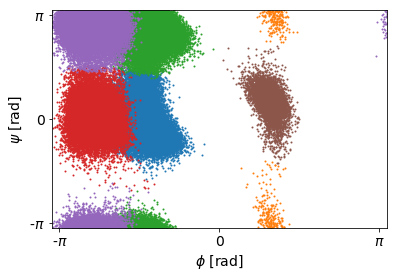

In [30]:
fig, ax = plt.subplots()

range_mat = np.array([[-np.pi,np.pi],[-np.pi,np.pi]])

maxi_train = np.max(pred, axis= 1)
coor_train = np.zeros_like(pred)
for i in range(output_size):
    coor_train = np.where(pred[:,i]== maxi_train)[0]
    ax.scatter(dihedral[coor_train,0], dihedral[coor_train,1], s=1)
    
ax.set_xlim(-np.pi,np.pi)
ax.set_ylim(-np.pi,np.pi)

if filter_data:
    e = matplotlib.patches.Rectangle(*mplt_filt1, color='k')
    e.set_clip_box(ax.bbox)
    e.set_alpha(0.2)
    ax.add_artist(e)
    
font = {'fontsize': 14}
ax.set_xticks([-3,0,3])
ax.set_yticks([-3,0,3])
ax.set_xticklabels([r'-$\pi$','0', r'$\pi$'], fontdict=font)
ax.set_yticklabels([r'-$\pi$','0', r'$\pi$'], fontdict=font)
ax.set_xlabel(r'$\phi$ [rad]', fontsize = 14)
ax.set_ylabel(r'$\psi$ [rad]', fontsize = 14)
plt.show()


In [31]:
def estimate_K_vampe(traj_ord_lag):

    chi_xtau = sess.run(chi_out, feed_dict = {x_t: traj_ord_lag, keep_prob_drop : 1.})
    gamma_xtau = sess.run(gamma_out, feed_dict = {x_tau: traj_ord_lag, keep_prob_drop : 1.})

    gamma_mean = 1/(np.mean(gamma_xtau, axis = 0) + regularizer)

    K = np.empty((output_size, output_size))

    for i in range(output_size):
        for j in range(output_size):
            K[i,j] = np.mean(gamma_mean[i]*gamma_xtau[:,i]*chi_xtau[:,j], axis = 0)
            
    return K

In [32]:
K = estimate_K_vampe(traj_ord_lag)

eigv, eigw = np.linalg.eig(K)

eig_sort = np.argsort(eigv)[::-1]

eigv = eigv[eig_sort]
eigw = eigw[:, eig_sort]

# Generative Model

In [33]:
def reset_weights_gen():
    sess.run([init_var_gen, init_adam_gen])

reset_weights_gen()

In [34]:
chi_ord = sess.run(chi_out, feed_dict = {x_t: traj_ord, keep_prob_drop : 1.})
chi_ord_lag = sess.run(chi_out, feed_dict = {x_t: traj_ord_lag, keep_prob_drop : 1.})

chi_shuffle = chi_ord[shuffle_index]
chi_shuffle_lag = chi_ord_lag[shuffle_index]

chi_data_train = chi_shuffle[:length_train]
chi_data_train_lag = chi_shuffle_lag[:length_train]

chi_data_valid = chi_shuffle[length_train:]
chi_data_valid_lag = chi_shuffle_lag[length_train:]

# Input of the first network
chi_X1_train = chi_data_train.astype('float32')
chi_X2_train  = chi_data_train_lag.astype('float32')

# Input for validation
chi_X1_vali = chi_data_valid.astype('float32')
chi_X2_vali = chi_data_valid_lag.astype('float32')

In [35]:
def sample_from_dist(dist, arg_max = False, cumsum = False):
    sample_num, sample_size = dist.shape
    drawn_values = np.random.rand(sample_num)
    sample_retval = np.zeros_like(dist)
    if cumsum:
        sample_cumsum = dist
    else:
        sample_cumsum = np.cumsum(dist, axis = 1)
    
    sample_diff = sample_cumsum - np.tile(drawn_values,(sample_size,1)).T
    sample_sign = np.sign(sample_diff)
    sample_argmax = np.argmax(sample_sign, axis = 1)
    
    if arg_max: 
        return sample_argmax
    sample_retval[np.arange(sample_num), sample_argmax] = 1
    
    return sample_retval

def get_mini_batch_gen(batchsize, index, sample_1, sample_2, train = True):
    
    start = index*batchsize
    end = (index+1)*batchsize
    if index==0 and train:
        sample_1 = sample_from_dist(chi_X1_train)
        sample_2 = sample_from_dist(chi_X1_train)
    if(end < length_train):
    
        
        batch_traj_1 = sample_1[start : end]
        batch_traj_2 = sample_2[start : end]
        batch_traj_lag = X2_train[start:end]
    else:
        batch_traj_1 = sample_1[start:]
        batch_traj_2 = sample_2[start:]
        batch_traj_lag = X2_train[start:]
    if index==0 and train:
        return batch_traj_1, batch_traj_2, batch_traj_lag, sample_1, sample_2
    else:
        return batch_traj_1, batch_traj_2, batch_traj_lag

In [36]:
trainings_completed_gen = 0

In [37]:
sess.run([init_var_gen, init_adam_gen, init_adam_gam]);

In [38]:
# batch_size_gen = 256 # not over 2100 because the lowest populated is
batches = np.ceil(length_train/batch_size_gen).astype('int')
best_value = 1.

### Sample training data before 

In [40]:
saver = tf.train.Saver(var_koop + var_gen + tf.global_variables())

if load_gen_model:
    saver.restore(sess, "./saved_models/best_ala_gen_model_equal.ckpt")
    
    if False:
        save_path = saver.save(sess, "./saved_models/best_ala_gen_model_equal.ckpt")

In [41]:
train_sample_1 = np.zeros_like(chi_data_train)
train_sample_2 = np.zeros_like(chi_data_train)

In [42]:
epochs = 200
plot_save_every = 25
offset = trainings_completed_gen

stochastic_gradient = False
lr_gentemp = lr_gen / 100000.

# compute distribution of training data
if stochastic_gradient:
    output_nodes_list = [solver_gen_sg, 
#                      loss_gen,
                          ]
else:
    output_nodes_list = [solver_gen, 
#                      loss_gen,
                          ]
flag = False

for run in range(epochs):
    if flag:
        break    
    loss_curr = []
    loss_vali_curr = []
    
    for batch in range(batches):
        # Get data for minibatch
        if batch ==0:
            batch_traj_1, batch_traj_2, batch_traj_lag, train_sample_1, train_sample_2 = get_mini_batch_gen(batch_size_gen, batch, train_sample_1, train_sample_2)
        else:
            batch_traj_1, batch_traj_2, batch_traj_lag = get_mini_batch_gen(batch_size_gen, batch, train_sample_1, train_sample_2)
        
        if stochastic_gradient:
            training_dict = {gen_chi_tau: batch_traj1,
                             gen_chi_tau2: batch_traj_2,
                           gen_x_tau: batch_traj_lag,
                           keep_prob_drop : (1.-dropout),
                             lr_tensor : lr_gentemp
                          }
        else:
            training_dict = {gen_chi_tau: batch_traj_1,
                             gen_chi_tau2: batch_traj_2,
                           gen_x_tau: batch_traj_lag,
                           keep_prob_drop : (1.-dropout),
                          }

        # Create Input for Training D
        # Train Dyn
        _ = sess.run(output_nodes_list,
                                        feed_dict=training_dict)
    for batch in range(batches):
        batch_traj_1, batch_traj_2, batch_traj_lag = get_mini_batch_gen(batch_size_gen, batch, train_sample_1, train_sample_2, train=False)
        training_dict = {gen_chi_tau: batch_traj_1,
                         gen_chi_tau2: batch_traj_2,
                       gen_x_tau: batch_traj_lag,
                       keep_prob_drop : (1.-dropout),
                      }
        loss_temp1 = sess.run(loss_gen, feed_dict=training_dict)
        # Write to Summary
#         validation_dict = {gen_chi_tau : sample_from_dist(chi_X1_vali @ K),
#                            gen_x_tau :  X2_vali,
#                            keep_prob_drop : 1.}
#         loss_vali_temp = sess.run(loss_gen, feed_dict=validation_dict)

#         if (np.isnan(loss_temp1)):
#             print('found NAN in batch {}'.format(batch))
#             flag = True
#             break
            
        loss_curr.append(loss_temp1)
#         loss_vali_curr.append(loss_vali_temp)
        
    loss_np = np.mean(loss_curr)
    if loss_np < best_value :
        best_value = loss_np
#         if conditioned_dist:
#             print('Save cond: {}'.format(best_value))
#             save_path = saver.save(sess, "./saved_models/best_ala_gen_model_test2.ckpt")
#         else:
#             save_path = saver.save(sess, "./saved_models/best_ala_gen_model_test2_equal.ckpt")
#     loss_vali = np.mean(loss_vali_curr)

    # Create a new Summary object with your measure
    summary = tf.Summary()
    summary.value.add(tag="loss_gen_equal", simple_value=loss_np)

    # Add it to the Tensorboard summary writer
    # Make sure to specify a step parameter to get nice graphs over time
    writer.add_summary(summary, run+offset)  
    
    if run % plot_save_every == 0:
        print('Iter: {}'.format(run))
        print('Loss: {:.4}'.format(loss_np))
#         print('Loss vali: {:.4}'.format(loss_vali))
        print()
        
trainings_completed_gen += epochs

Iter: 0
Loss: 0.2781

Iter: 25
Loss: 0.1667

Iter: 50
Loss: 0.1664

Iter: 75
Loss: 0.1679

Iter: 100
Loss: 0.1668

Iter: 125
Loss: 0.1679

Iter: 150
Loss: 0.1665

Iter: 175
Loss: 0.167



# Calculate cond. probs

In [130]:
def get_points_in_square(dih, c, l):
    
            
    dht = np.array(dih.T)
    
    xlim = np.array([c[0]-l/2,c[0]+l/2])
    ylim1 = np.array([c[1]-l/2,c[1]+l/2])
    
    if ylim1[1] < np.pi and ylim1[0] > -np.pi:
        filters_num = 1
        ylim2 = None
        
    elif ylim1[0] < -np.pi:
        filters_num = 2
        ylim2  = np.array([2*np.pi + ylim1[0], np.pi])
        ylim1[0] = - np.pi
        
    else:
        ylim2  = np.array([-np.pi, -2*np.pi + ylim1[1]])
        ylim1[1] = np.pi
        filters_num = 2

    conds = np.empty((dht.shape[1], filters_num))

    
    for index_ylim, ylim in enumerate([ylim1, ylim2]):       
        if index_ylim < filters_num:
            
            cond_1 = dht[0] < xlim[0]
            cond_2 = dht[0] > xlim[1]
            
            cond_3 = dht[1] < ylim[0]
            cond_4 = dht[1] > ylim[1]

            conds[:,index_ylim] = np.any([cond_1, cond_2, cond_3, cond_4], axis = 0)
    
    indexes_filt = np.where(np.logical_not(conds))[0]

    return indexes_filt

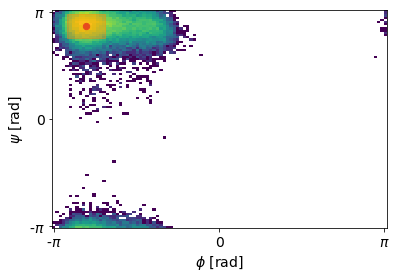

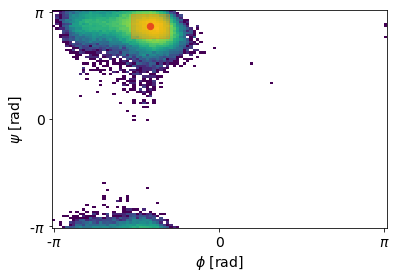

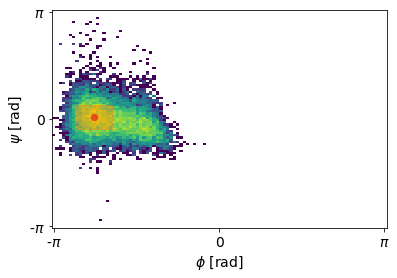

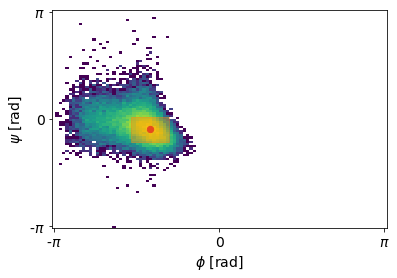

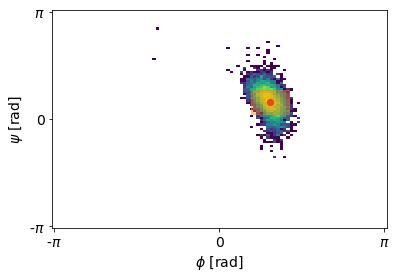

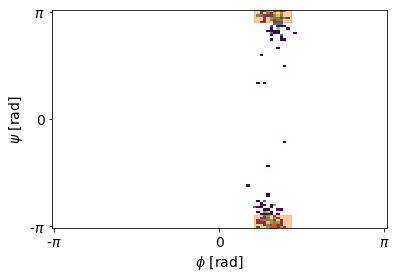

In [172]:
dihedral_lag = dihedral[tau:]
gen_cond_points = np.zeros((6), dtype = int)

for r in range(6):
    
    filt_center =  dihedral[state_centers[r]]
    filt_rad = 0.7
    
    dih_center = get_points_in_square(dihedral, filt_center, filt_rad)
    gen_cond_points[r] = len(dih_center)
    
    fig, ax = plt.subplots()

    range_mat = np.array([[-np.pi,np.pi],[-np.pi,np.pi]])

    hist_im = ax.hist2d(*dihedral_lag[dih_center].T, bins=100, range = range_mat, norm=matplotlib.colors.LogNorm(), cmap = plt.cm.viridis, normed = True)
    ax.scatter(*dihedral[state_centers[r]], s=40, c='C3')
    
    e = matplotlib.patches.Rectangle(filt_center-filt_rad/2, filt_rad, filt_rad, color='C1')
    e.set_clip_box(ax.bbox)
    e.set_alpha(0.4)
    ax.add_artist(e)
    
    if r == 5:
        new_fc = filt_center-filt_rad/2 + [0, 2*np.pi]
        e2 = matplotlib.patches.Rectangle(new_fc, filt_rad, filt_rad, color='C1')
        e2.set_clip_box(ax.bbox)
        e2.set_alpha(0.4)
        ax.add_artist(e2)
        
    
    ax.set_xlim(-np.pi,np.pi)
    ax.set_ylim(-np.pi,np.pi)
    font = {'fontsize': 14}
    ax.set_xticks([-3.1,0,3.1])
    ax.set_yticks([-3.1,0,3.1])
    ax.set_xticklabels([r'-$\pi$','0', r'$\pi$'], fontdict=font)
    ax.set_yticklabels([r'-$\pi$','0', r'$\pi$'], fontdict=font)
    ax.set_xlabel(r'$\phi$ [rad]', fontsize = 14)
    ax.set_ylabel(r'$\psi$ [rad]', fontsize = 14)
    fig.savefig('cond_dist_real_state{}.pdf'.format(r), bbox_inches='tight')

#     plt.colorbar(hist_im[-1], ax = ax)
    plt.show()

In [196]:
grid_points = 6
cond_points = gen_cond_points.max()



predict_cond = np.empty((grid_points, cond_points, input_size))

starting_pools = []

for r in range(grid_points):

    filt_center =  dihedral[state_centers[r]]
    filt_rad = 0.7

    dih_center = get_points_in_square(dihedral, filt_center, filt_rad)
    starting_pools.append(dih_center)

In [197]:
for index_cond in range(cond_points):

    indexes_best_dih = np.empty((grid_points), dtype = int)
    for r in range(grid_points):
        indexes_best_dih[r] = np.random.choice(starting_pools[r])

    temp = sess.run(chi_out, feed_dict = {x_t: traj_ord[indexes_best_dih], keep_prob_drop : 1.})


    temp_samp = sample_from_dist(temp)
    predict_cond[:,index_cond] = sess.run(gen_x1, feed_dict = {gen_chi_tau: temp_samp, keep_prob_drop : 1.})[:,:]

In [198]:
mol_gen = md.load_dcd('/group/ag_cmb/scratch/deeptime_data/ala2.dcd', top='/group/ag_cmb/scratch/deeptime_data/ala2.pdb')[:cond_points]
idx_heavy = [a for a in range(mol_gen.n_atoms) if mol_gen.topology.atom(a).element.symbol != 'H']
mol_gen_small = mol_gen.atom_slice(idx_heavy)

In [199]:
dihedrals_cond = np.zeros((cond_points, 6, 2))
for i in range(6):
    mol_gen_small.xyz = predict_cond[i].reshape(-1, mol_gen_small.n_atoms, 3)
    dihedrals_cond[:,i] = md.compute_dihedrals(mol_gen_small, dihedral_ind_small)

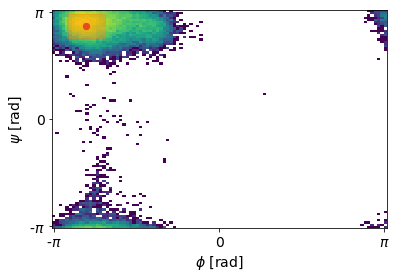

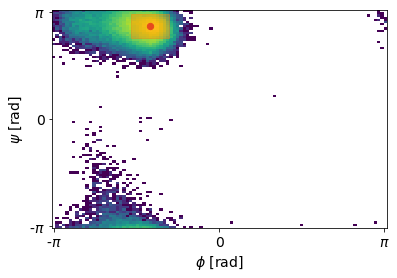

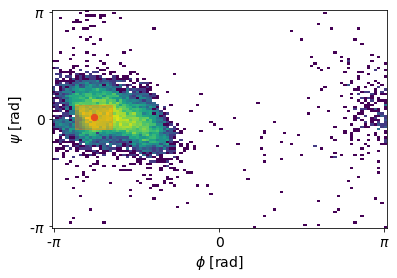

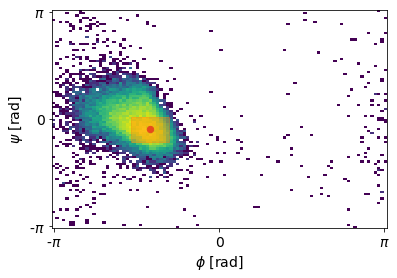

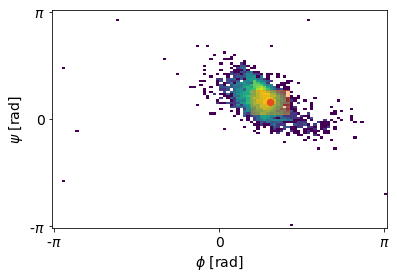

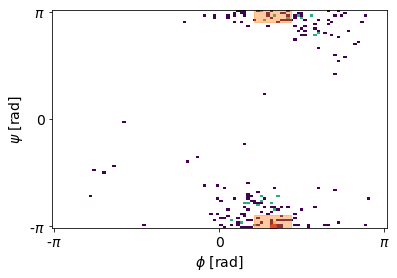

In [203]:
offset = 0.5
low = -np.pi - offset
for r in range(6):
    
    filt_center =  dihedral[state_centers[r]]
    filt_rad = 0.7
    
    
    fig, ax = plt.subplots()

    range_mat = np.array([[-np.pi,np.pi],[-np.pi,np.pi]])

    hist_im = ax.hist2d(*dihedrals_cond[:gen_cond_points[r],r].T, bins=100, range = range_mat, norm=matplotlib.colors.LogNorm(), cmap = plt.cm.viridis, normed = True)
    ax.scatter(*dihedral[state_centers[r]], s=40, c='C3')
    
    e = matplotlib.patches.Rectangle(filt_center-filt_rad/2, filt_rad, filt_rad, color='C1')
    e.set_clip_box(ax.bbox)
    e.set_alpha(0.4)
    ax.add_artist(e)
    
    if r == 5:
        new_fc = filt_center-filt_rad/2 + [0, 2*np.pi]
        e2 = matplotlib.patches.Rectangle(new_fc, filt_rad, filt_rad, color='C1')
        e2.set_clip_box(ax.bbox)
        e2.set_alpha(0.4)
        ax.add_artist(e2)
        
    
    ax.set_xlim(-np.pi,np.pi)
    ax.set_ylim(-np.pi,np.pi)
    font = {'fontsize': 14}
    ax.set_xticks([-3.1,0,3.1])
    ax.set_yticks([-3.1,0,3.1])
    ax.set_xticklabels([r'-$\pi$','0', r'$\pi$'], fontdict=font)
    ax.set_yticklabels([r'-$\pi$','0', r'$\pi$'], fontdict=font)
    ax.set_xlabel(r'$\phi$ [rad]', fontsize = 14)
    ax.set_ylabel(r'$\psi$ [rad]', fontsize = 14)
    fig.savefig('cond_dist_gen_state{}.pdf'.format(r), bbox_inches='tight')

#     plt.colorbar(hist_im[-1], ax = ax)
    plt.show()

In [44]:
grid_points = 1
cond_points = 10000


predict_stat = np.empty((cond_points, 30))
predict_stat[0,:] = traj_whole[0]

for index_cond in range(1, cond_points):
    temp = sess.run(chi_out, feed_dict = {x_t: predict_stat[index_cond-1][None,:], keep_prob_drop : 1.})
    temp_samp = sample_from_dist(temp)
    predict_stat[index_cond] = sess.run(gen_x1, feed_dict = {gen_chi_tau: temp_samp, keep_prob_drop : 1.})

In [45]:
mol_gen = md.load_dcd('/group/ag_cmb/scratch/deeptime_data/ala2.dcd', top='/group/ag_cmb/scratch/deeptime_data/ala2.pdb')[:cond_points]
idx_heavy = [a for a in range(mol_gen.n_atoms) if mol_gen.topology.atom(a).element.symbol != 'H']
mol_gen_small = mol_gen.atom_slice(idx_heavy)

In [46]:
dihedrals_gen = np.zeros((cond_points, 2))

mol_gen_small.xyz = predict_stat.reshape(-1, mol_gen_small.n_atoms, 3)
dihedrals_gen = md.compute_dihedrals(mol_gen_small, dihedral_ind_small)

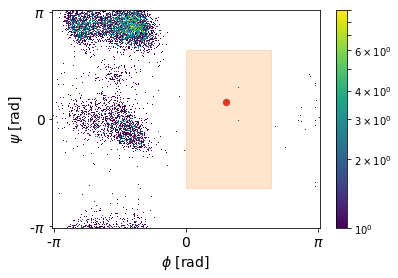

In [47]:
fig, ax = plt.subplots()

range_mat = np.array([[-np.pi,np.pi],[-np.pi,np.pi]])

hist_im = ax.hist2d(dihedrals_gen[:,0], dihedrals_gen[:,1], bins=300, range = range_mat, norm=matplotlib.colors.LogNorm(), cmap = plt.cm.viridis)
ax.scatter(dihedral[state_filt_index,0], dihedral[state_filt_index,1], s=40, c='C3')
ax.set_xlim(-np.pi,np.pi)
ax.set_ylim(-np.pi,np.pi)
e = matplotlib.patches.Rectangle(*mplt_filt1, color='C1')
e.set_clip_box(ax.bbox)
e.set_alpha(0.2)
ax.add_artist(e)
if mplt_filt2:
    e2 = matplotlib.patches.Rectangle(*mplt_filt2, color='C1')
    e2.set_clip_box(ax.bbox)
    e2.set_alpha(0.2)
    ax.add_artist(e2)
font = {'fontsize': 14}
ax.set_xticks([-3.1,0,3.1])
ax.set_yticks([-3.1,0,3.1])
ax.set_xticklabels([r'-$\pi$','0', r'$\pi$'], fontdict=font)
ax.set_yticklabels([r'-$\pi$','0', r'$\pi$'], fontdict=font)
ax.set_xlabel(r'$\phi$ [rad]', fontsize = 14)
ax.set_ylabel(r'$\psi$ [rad]', fontsize = 14)
plt.colorbar(hist_im[-1], ax = ax)
# fig.savefig('generated_data_withoutKoop_removed_{}state.pdf'.format(state_to_be_filtered), bbox_inches='tight')
plt.show()

In [98]:
grid_points = 1
cond_points = length_data


predict_stat = np.empty((cond_points, 30))
predict_stat[0,:] = traj_whole[0]

for index_cond in range(1, cond_points):
    temp = sess.run(chi_out, feed_dict = {x_t: predict_stat[index_cond-1][None,:], keep_prob_drop : 1.})
    temp_samp = sample_from_dist(temp)
    predict_stat[index_cond] = sess.run(gen_x1, feed_dict = {gen_chi_tau: temp_samp, keep_prob_drop : 1.})

In [99]:
mol_gen = md.load_dcd('/group/ag_cmb/scratch/deeptime_data/ala2.dcd', top='/group/ag_cmb/scratch/deeptime_data/ala2.pdb')[:cond_points]
idx_heavy = [a for a in range(mol_gen.n_atoms) if mol_gen.topology.atom(a).element.symbol != 'H']
mol_gen_small = mol_gen.atom_slice(idx_heavy)

In [100]:
dihedrals_gen = np.zeros((cond_points, 2))

mol_gen_small.xyz = predict_stat.reshape(-1, mol_gen_small.n_atoms, 3)
dihedrals_gen = md.compute_dihedrals(mol_gen_small, dihedral_ind_small)

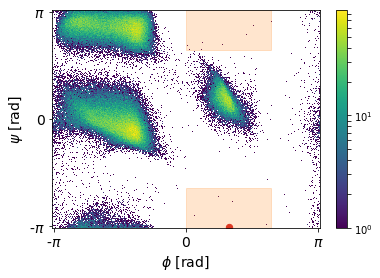

In [101]:
fig, ax = plt.subplots()

range_mat = np.array([[-np.pi,np.pi],[-np.pi,np.pi]])

hist_im = ax.hist2d(dihedrals_gen[:,0], dihedrals_gen[:,1], bins=300, range = range_mat, norm=matplotlib.colors.LogNorm(), cmap = plt.cm.viridis)
ax.scatter(dihedral[state_filt_index,0], dihedral[state_filt_index,1], s=40, c='C3')
ax.set_xlim(-np.pi,np.pi)
ax.set_ylim(-np.pi,np.pi)
e = matplotlib.patches.Rectangle(*mplt_filt1, color='C1')
e.set_clip_box(ax.bbox)
e.set_alpha(0.2)
ax.add_artist(e)
if mplt_filt2:
    e2 = matplotlib.patches.Rectangle(*mplt_filt2, color='C1')
    e2.set_clip_box(ax.bbox)
    e2.set_alpha(0.2)
    ax.add_artist(e2)
font = {'fontsize': 14}
ax.set_xticks([-3.1,0,3.1])
ax.set_yticks([-3.1,0,3.1])
ax.set_xticklabels([r'-$\pi$','0', r'$\pi$'], fontdict=font)
ax.set_yticklabels([r'-$\pi$','0', r'$\pi$'], fontdict=font)
ax.set_xlabel(r'$\phi$ [rad]', fontsize = 14)
ax.set_ylabel(r'$\psi$ [rad]', fontsize = 14)
plt.colorbar(hist_im[-1], ax = ax)
# fig.savefig('generated_data_withoutKoop_removed_{}state.pdf'.format(state_to_be_filtered), bbox_inches='tight')
plt.show()

In [102]:
generated_closest_points = np.argsort(np.linalg.norm(dihedrals_gen[:] - dihedral[state_filt_index], axis = 1))[:100]
gen_filter_traj = predict_stat[generated_closest_points]

In [103]:
mol_gen_fil = md.load_dcd('/group/ag_cmb/scratch/deeptime_data/ala2.dcd', top='/group/ag_cmb/scratch/deeptime_data/ala2.pdb')[:gen_filter_traj.shape[0]+1]
idx_heavy = [a for a in range(mol_gen.n_atoms) if mol_gen.topology.atom(a).element.symbol != 'H']
mol_gen_fil_small = mol_gen_fil.atom_slice(idx_heavy)
mol_gen_fil_small.xyz = np.concatenate([traj_whole[state_filt_index].reshape(-1,10,3), gen_filter_traj.reshape(-1,10,3)], axis = 0)
mol_gen_fil_small.save_pdb('/group/ag_cmb/scratch/deeptime_data/gen_data_withoutKoop_ala_filt_state{}.pdb'.format(state_to_be_filtered))

In [104]:
closest_structures_index = np.argsort(np.linalg.norm(predict_stat - traj_whole[state_filt_index], axis = 1))[:100]
closest_structures = predict_stat[closest_structures_index]

In [105]:
mol_gen_fil = md.load_dcd('/group/ag_cmb/scratch/deeptime_data/ala2.dcd', top='/group/ag_cmb/scratch/deeptime_data/ala2.pdb')[:closest_structures.shape[0]+1]
idx_heavy = [a for a in range(mol_gen.n_atoms) if mol_gen.topology.atom(a).element.symbol != 'H']
mol_gen_fil_small = mol_gen_fil.atom_slice(idx_heavy)
mol_gen_fil_small.xyz = np.concatenate([traj_whole[state_filt_index].reshape(-1,10,3), closest_structures.reshape(-1,10,3)], axis = 0)
mol_gen_fil_small.save_pdb('/group/ag_cmb/scratch/deeptime_data/gen_data_withoutKoop_ala_closest_filt_state{}.pdb'.format(state_to_be_filtered))